# Ajuste de modelo aos dados de COVID-19

Este notebook procura ajustar o modelo aos dados de COVID explicado no artigo para estimar parâmetros necessários. O texto referência principal é o arquivo na pasta `notes`.

## Modelo SEIAQR

Esse é um modelo compartimental baseado [nesse artigo](https://doi.org/10.1016/j.epidem.2021.100437).

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import norm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
import statsmodels.api as sm
sns.set()

import sys
sys.path.append('../pyscripts/')

from estimation import Fitting 

## Dados utilizados 

A construção desse conjunto de dados foi explicada no notebook `data_analysis.ipynb`. 

In [4]:
data_rio = pd.read_csv('../data/covid_data_organized.csv', index_col = 0)
data_rio.index = pd.to_datetime(data_rio.index)
data_rio.head()

,confirmed,deaths
2020-03-02,0.000002,0.0
2020-03-03,0.000004,0.0
2020-03-04,0.000006,0.0
2020-03-05,0.000008,0.0
2020-03-06,0.000010,0.0


## Experimentação

Nessa seção, é possível realizar diversos experimentos e observar que eles vão sendo salvos para posterior comparação. Esses valores foram usados para o exemplo contido no texto. 

### Primeiro vamos setar os parâmetros

In [5]:
tau    = 1/3.69
omega  = 1/5.74
sigma  = 1/(1/omega - 1/tau)
rho    = 1e-4
delta  = 0.01
gamma1 = 1/7.5
gamma2 = 1/13.4

In [6]:
p = [tau, sigma, rho, delta, gamma1, gamma2]

# sbeta is number of coefficients, bspline order speaks for itself
time_varying = {'beta': {'coefficients':  4, 'bspline_order': 2}, 
               'mu'  : {'coefficients': 4, 'bspline_order': 1}}

# initial and final day in the model
initial_day = '2020-03-16'
final_day = '2020-07-31'

# initial conditions guesses and bounds
init_cond = {'x0': [0.8, 0.3, 5e-7, 5e-7, 5e-7], 
             'bounds': [(0.5,1), (0,1), (1e-7, 5e-5), (1e-7, 5e-5), (1e-7, 5e-5)]}
# hmax
hmax = 0.2

# bound the parameters
bounds = [(0.7, 0.95), 
          (0.05, 0.2), (0.05, 0.2), (0.05, 0.2), (0.05, 0.2), 
          (0.005, 0.02), (0.005,0.02), (0.005, 0.02), (0.005, 0.02)] 

# initial guess
x0 = [0.9,                        # alpha
      0.11, 0.08, 0.09, 0.12,     # beta
      0.015, 0.015, 0.011, 0.009] # mu

## Definindo modelo e estimando os parâmetros.

In [7]:
# weight of the curves 
psi = data_rio.confirmed[initial_day:].var() / data_rio.deaths[initial_day:].var()
psi

119.56329270977572

In [8]:
# defines the model
model = Fitting(p, time_varying, initial_day, final_day, hmax, init_cond)

# estimating theta
theta = model.fit(psi, x0, bounds)

Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Starting estimation!
Estimation finished. It took 27.133483171463013 seconds


In [9]:
theta

array([0.89819062, 0.14302706, 0.07245962, 0.1015016 , 0.12658061,
       0.00997155, 0.01593937, 0.010313  , 0.00699443])

Salvando o resultado do modelo

In [9]:
model.save_experiment(objective_function = 'quadratic_normal')

## Resultados

Vamos averiguar os resultados da estimação.

### Início da pandemia

In [10]:
days = data_rio.confirmed['2020-03-02':initial_day].index

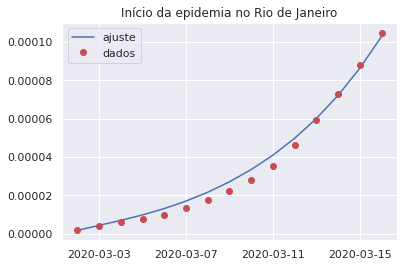

In [11]:
_, ax = plt.subplots()
ax.plot(days, model.initial_phase[:,3], label = 'ajuste')
ax.plot(days, data_rio.confirmed['2020-03-02':initial_day].to_numpy(), 'ro', label = 'dados')
ax.xaxis.set_major_locator(plt.MaxNLocator(4))
ax.set_title('Início da epidemia no Rio de Janeiro')
ax.legend()
plt.savefig('../images/initial_values.png', bbox_inches='tight', dpi = 400)
plt.show()

### Epidemia

Vamos visualizar o resultado gráfico dos ajustes às curvas de casos confirmados e de mortes. 

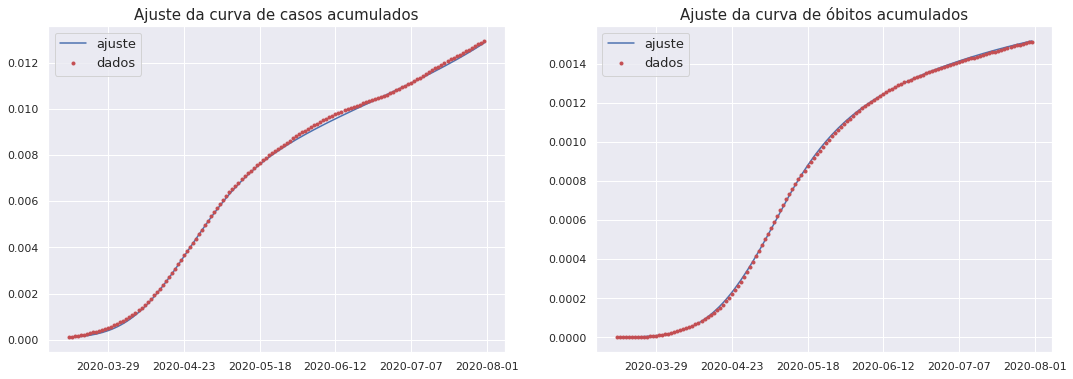

In [12]:
T = model.integrate(theta, p)[:,7]
D = model.integrate(theta, p)[:,6]

days = data_rio[initial_day:final_day].index

fig, ax = plt.subplots(1,2, figsize = (18,6))
ax[0].plot(days, T, label = 'ajuste')
ax[0].plot(days, model.T, 'ro', markersize = 3, label = 'dados')
ax[1].plot(days, D, label = 'ajuste')
ax[1].plot(days, model.D, 'ro', markersize = 3, label = 'dados')

ax[0].set_title('Ajuste da curva de casos acumulados', fontsize = 15)
ax[0].xaxis.set_major_locator(plt.MaxNLocator(7))
ax[1].set_title('Ajuste da curva de óbitos acumulados', fontsize = 15)
ax[1].xaxis.set_major_locator(plt.MaxNLocator(7))
ax[0].legend(fontsize = 13)
ax[1].legend(fontsize = 13)
plt.savefig('../images/cumulated_fitted_curves.png', bbox_inches='tight', dpi = 400)
plt.show()

### Valores estimados

Observamos que $\alpha$ foi estimado em 0.9 e em seguida vemos, respectivamente, os coeficientes de $\beta$ e de $\mu$. 

In [13]:
theta 

array([0.89819062, 0.14302706, 0.07245962, 0.1015016 , 0.12658061,
       0.00997155, 0.01593937, 0.010313  , 0.00699443])

### Rate of underreporting 

Here we consider the rate of non-infected over the total number of infected.

In [14]:
infected = 1 - model.states[:,4]
tested = model.states[:,7]

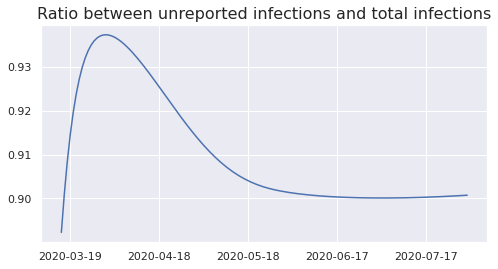

In [15]:
fig, ax = plt.subplots(figsize = (8,4))

ax.plot(days, 1 - tested/infected)
ax.set_title(r'Ratio between unreported infections and total infections', fontsize=16)
ax.xaxis.set_major_locator(plt.MaxNLocator(6))
plt.savefig('../images/ratio-infected.eps', bbox_inches = 'tight', dpi = 400)
plt.show()

In [16]:
np.mean(1 - tested/infected)

0.9102760957767535

Esse é o resultado da otimização. 

In [17]:
model.res

      fun: 2.179044856365313e-06
 hess_inv: <9x9 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.69175384e-06, -3.60870523e-06, -2.57292098e-06,  7.32131776e-06,
        4.07112118e-06,  8.56092558e-07, -4.14983125e-07,  1.88995527e-06,
       -2.39614673e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 250
      nit: 22
     njev: 25
   status: 0
  success: True
        x: array([0.89819062, 0.14302706, 0.07245962, 0.1015016 , 0.12658061,
       0.00997155, 0.01593937, 0.010313  , 0.00699443])

### Número de reprodução como função do tempo

Após o fitting, o cálculo do número reprodutivo básico é automático. 

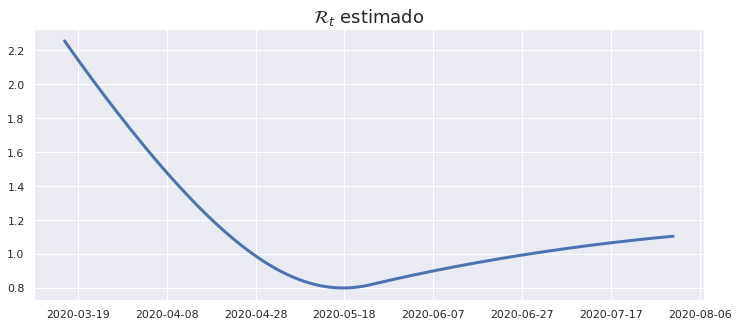

In [18]:
fig, ax = plt.subplots(figsize = (12,5))
ax.plot(days, model.repro_number[1,:], linewidth = 3)
ax.set_title('$\mathcal{R}_t$ estimado', fontsize = 18)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
#plt.hlines(xmin = initial_day, xmax = final_day, y = 1, 
#           linestyle = '--', color = 'red', alpha = 0.5)
plt.savefig('../images/rt_example.png', bbox_inches = 'tight', dpi = 400)
plt.show()

### Histograma dos resíduos e QQ-Plot

Nessa seção, verificamos as hipóteses sobre os erros do modelo. Em particular, podemos visualizar que os histrograas tem uma similaridade com a distribuição normal (unimodal, aproximadamente simétrica)

/home/lucasmoschen/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/home/lucasmoschen/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


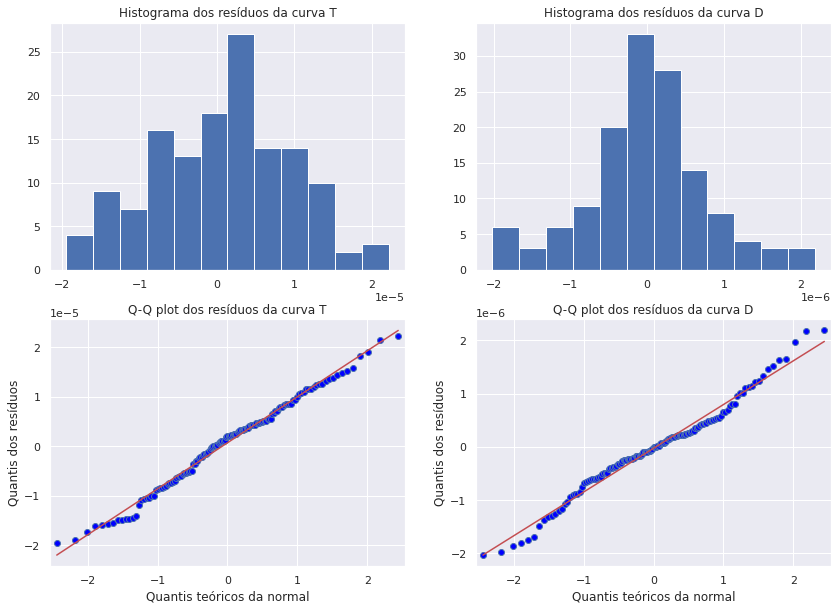

In [19]:
errorT, errorD = model.check_residuals()

fig, ax = plt.subplots(2,2,figsize = (14,10))
ax[0][0].hist(errorT, bins = 12)
ax[0][1].hist(errorD, bins = 12)
qqplot(errorT, line = 'r', ax = ax[1][0])
qqplot(errorD, line = 'r', ax = ax[1][1])
ax[0][0].set_title('Histograma dos resíduos da curva T')
ax[0][1].set_title('Histograma dos resíduos da curva D')
ax[1][0].set_title('Q-Q plot dos resíduos da curva T')
ax[1][1].set_title('Q-Q plot dos resíduos da curva D')
ax[1][0].set_xlabel('Quantis teóricos da normal')
ax[1][1].set_xlabel('Quantis teóricos da normal')
ax[1][0].set_ylabel('Quantis dos resíduos')
ax[1][1].set_ylabel('Quantis dos resíduos')
plt.savefig('../images/check_residuals.png', bbox_inches = 'tight', dpi = 400)
plt.show()

### Testes estatísticos

#### Ljung-Box

O teste Ljung-Box testa se as k−correlações do modelo são nulas. Isto é,
a hipótese nula é que os dados são distribuídos de forma descorrelacionada,
enquanto a alternativa é que alguma autocorrelação é não nula. Em particular, rejeitamos a hipótese nula de descorrelação. 

In [20]:
print(acorr_ljungbox(errorT, lags = 10, return_df = True))
print(acorr_ljungbox(errorD, lags = 10, return_df = True))

       lb_stat     lb_pvalue
1    85.231197  2.654407e-20
2   132.574714  1.628421e-29
3   166.633409  6.782960e-36
4   197.274301  1.448275e-41
5   224.625429  1.517058e-46
6   234.581071  8.058767e-48
7   235.344743  3.629897e-47
8   236.574863  1.202669e-46
9   239.945791  1.319254e-46
10  243.631788  1.183072e-46
       lb_stat     lb_pvalue
1   120.728285  4.382237e-28
2   223.422309  3.051139e-49
3   297.559641  3.356791e-64
4   348.921929  2.997411e-74
5   377.062321  2.599241e-79
6   390.247235  3.490847e-81
7   392.443264  9.950824e-81
8   392.482703  7.591720e-80
9   396.587088  7.325516e-80
10  408.017844  1.849239e-81


#### Jarque Bera

Já o teste Jarque-Beta é sobre a assimetria e a curtose da distribuição normal.
A hipótese nula é que a assimetria é 0 e excesso de curtose 3.

In [21]:
print(jarque_bera(errorT/np.mean(errorT)))
print(jarque_bera(errorD/np.mean(errorD)))

(1.4887234042727913, 0.4750374185590359, -0.11770927868806895, 2.5468153097847734)
(1.8522446375906516, 0.3960866340524106, -0.05192993332191953, 3.560083869188681)


### Curvas de mortalidade e transmissibilidade

As curvas de transmissibilidade e mortalidade geradas por essa estimação foram:

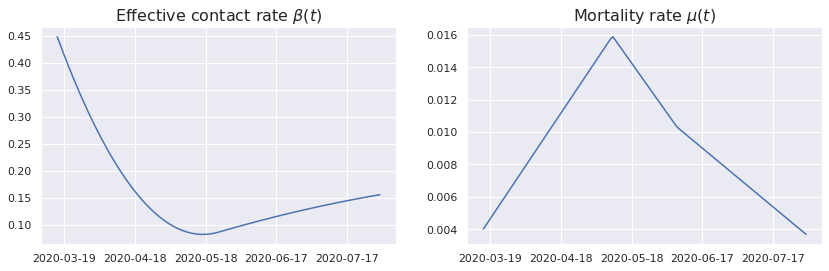

In [22]:
t = np.linspace(0, model.tf, len(days))

fig, ax = plt.subplots(1,2,figsize = (14,4))
ax[0].plot(days, model.beta(t))
ax[0].set_title(r'Effective contact rate $\beta(t)$', fontsize=16)
ax[0].xaxis.set_major_locator(plt.MaxNLocator(6))
ax[1].plot(days, np.maximum(model.mu(t), 0))
ax[1].set_title(r'Mortality rate $\mu(t)$', fontsize=16)
ax[1].xaxis.set_major_locator(plt.MaxNLocator(6))
plt.savefig('../images/beta_mu_curves.eps', bbox_inches = 'tight', dpi = 400)
plt.show()


## Comparação de modelos segundo AIC

Variamos os coeficientes para definição das BSplines e calculos o Critério de Informação AIC. Outros critérios como BIC e AICc também estão disponíveis. 

## Modelo escolhido

Segundo o AIC, o modelo escolhido é o seguinte. Os resultados não diferem muito do exemplo citado. Os resultados foram melhores do que para os escolhidos acima.  

In [23]:
time_varying = {'beta': {'coefficients':  4, 'bspline_order': 2}, 
               'mu'  : {'coefficients': 4, 'bspline_order': 1}}

# bound the parameters
bounds = [(0.7, 0.95), 
          (0.05, 0.2), (0.05, 0.2), (0.05, 0.2), (0.05, 0.2), 
          (0.005, 0.02), (0.005,0.02), (0.005, 0.02), (0.005, 0.02)] 

# initial guess
x0 = [0.9,                        # alpha
      0.11, 0.08, 0.09, 0.12,     # beta
      0.015, 0.015, 0.011, 0.009] # mu

model = Fitting(p, time_varying, initial_day, final_day, hmax, init_cond)
theta = model.fit(psi, x0, bounds)

model.save_experiment(objective_function = 'quadratic_normal')

T = model.integrate(theta, p)[:,7]
D = model.integrate(theta, p)[:,6]
errorT, errorD = model.check_residuals()

Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Starting estimation!
Estimation finished. It took 27.42303490638733 seconds


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
/home/lucasmoschen/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)
/home/lucasmoschen/anaconda3/lib/python3.9/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


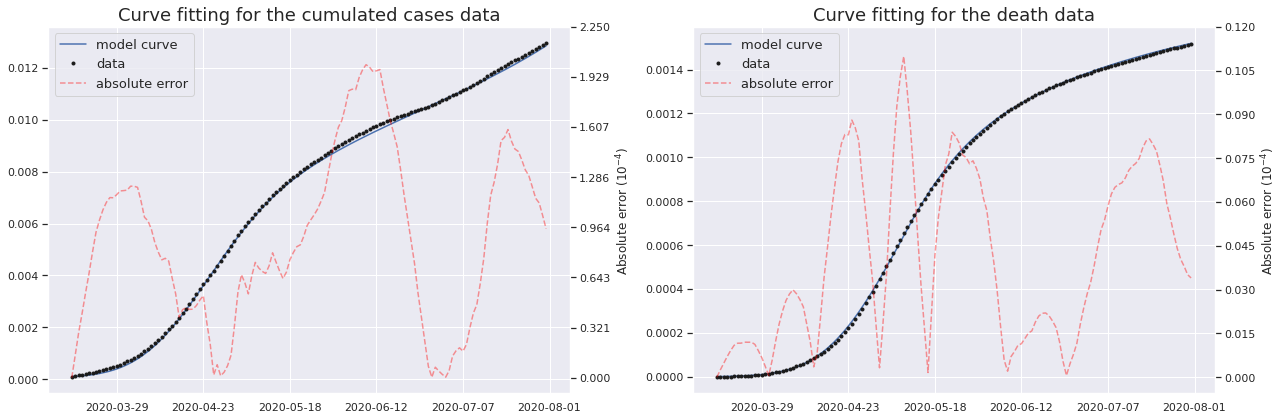

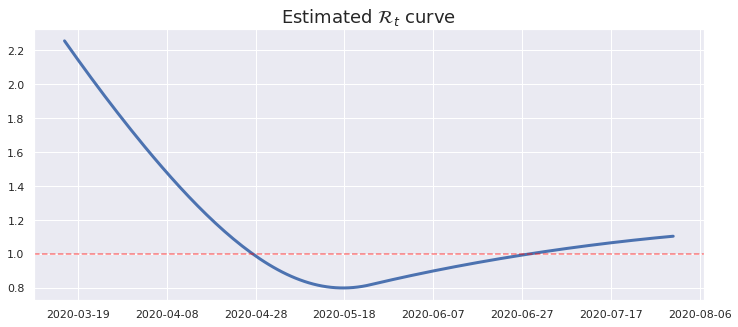

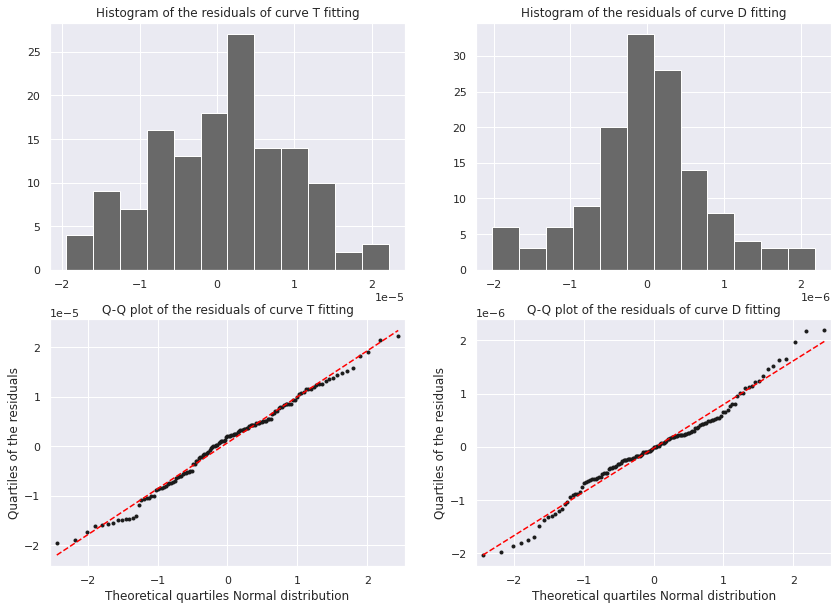

In [24]:
fig, ax = plt.subplots(1,2, figsize = (18,6))
ax0_2 = ax[0].twinx()
ax1_2 = ax[1].twinx()

lns1T = ax[0].plot(days, T, label = 'model curve')
lns2T = ax[0].plot(days, model.T, 'ko', markersize = 3, label = 'data')
lns1D = ax[1].plot(days, D, label = 'model curve')
lns2D = ax[1].plot(days, model.D, 'ko', markersize = 3, label = 'data')
lns3T = ax0_2.plot(days, 1e4*abs(T - model.T), linestyle='--', color='red', alpha=0.4, label='absolute error')
lns3D = ax1_2.plot(days, 1e4*abs(D - model.D), linestyle='--', color='red', alpha=0.4, label='absolute error')

ax[0].set_title('Curve fitting for the cumulated cases data', fontsize = 18)
ax[0].xaxis.set_major_locator(plt.MaxNLocator(7))
ax[1].set_title('Curve fitting for the death data', fontsize = 18)
ax[1].xaxis.set_major_locator(plt.MaxNLocator(7))

ax0_2.set_ylabel(r'Absolute error (10$^{-4}$)')
ax1_2.set_ylabel(r'Absolute error (10$^{-4}$)')
ax0_2.set_yticks(np.linspace(0, ax0_2.get_yticks()[-1], len(ax[0].get_yticks())-1))
ax1_2.set_yticks(np.linspace(0, ax1_2.get_yticks()[-1], len(ax[1].get_yticks())-1))

lnsT = lns1T+lns2T+lns3T
labsT = [l.get_label() for l in lnsT]
lnsD = lns1D+lns2D+lns3D
labsD = [l.get_label() for l in lnsD]
ax[0].legend(lnsT, labsT, loc=0, fontsize=13)
ax[1].legend(lnsD, labsD, loc=0, fontsize=13)

ax0_2.grid(None)
ax1_2.grid(None)

fig.tight_layout()
plt.savefig('../images/cumulated_fitted_curves.pdf', bbox_inches='tight')

fig, ax = plt.subplots(figsize = (12,5))
ax.plot(days, model.repro_number[1,:], linewidth = 3, color = 'b')
ax.set_title('Estimated $\mathcal{R}_t$ curve', fontsize = 18)
plt.axhline(y = 1, linestyle = '--', color = 'red', alpha = 0.5)
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.savefig('../images/rt_example.eps', bbox_inches = 'tight')

fig, ax = plt.subplots(2,2,figsize = (14,10))
ax[0][0].hist(errorT, bins = 12, color = 'dimgray')
ax[0][1].hist(errorD, bins = 12, color = 'dimgray')
qqplot(errorT, ax = ax[1][0], line='r',
       marker='.', markerfacecolor='k', markeredgecolor='k')
ax[1][0].get_lines()[1].set_color('red')
ax[1][0].get_lines()[1].set_linestyle('--')
qqplot(errorD, ax = ax[1][1], line='r',
       marker='.', markerfacecolor='k', markeredgecolor='k')
ax[1][1].get_lines()[1].set_color('red')
ax[1][1].get_lines()[1].set_linestyle('--')
ax[0][0].set_title('Histogram of the residuals of curve T fitting')
ax[0][1].set_title('Histogram of the residuals of curve D fitting')
ax[1][0].set_title('Q-Q plot of the residuals of curve T fitting')
ax[1][1].set_title('Q-Q plot of the residuals of curve D fitting')
ax[1][0].set_xlabel('Theoretical quartiles Normal distribution')
ax[1][1].set_xlabel('Theoretical quartiles Normal distribution')
ax[1][0].set_ylabel('Quartiles of the residuals')
ax[1][1].set_ylabel('Quartiles of the residuals')
plt.savefig('../images/check_residuals.eps', bbox_inches = 'tight')
plt.show()

Os valores estimados foram, então

In [101]:
theta

array([0.89809528, 0.1431444 , 0.07248326, 0.10149495, 0.12658465,
       0.00999117, 0.01594574, 0.01031947, 0.00698567])

In [102]:
corr_matrix = model.correlation_matrix()

/home/lucasmoschen/anaconda3/envs/covid/lib/python3.9/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


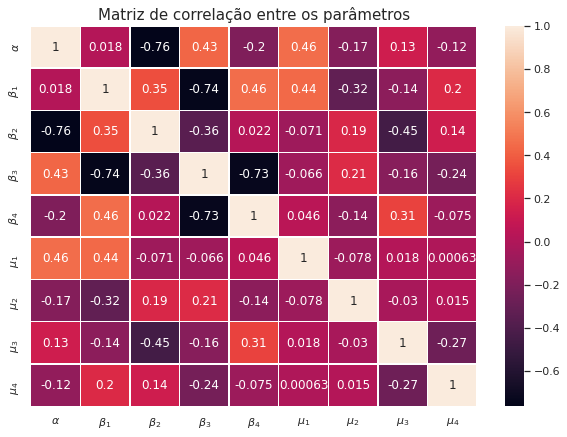

In [24]:
f, ax = plt.subplots(figsize=(10, 7))
ax = sns.heatmap(corr_matrix, linewidth=0.5, 
                 xticklabels=[r'$\alpha$', 
                              r'$\beta_1$', r'$\beta_2$', r'$\beta_3$', r'$\beta_4$', 
                              r'$\mu_1$', r'$\mu_2$', r'$\mu_3$', r'$\mu_4$'],
                 yticklabels=[r'$\alpha$', 
                              r'$\beta_1$', r'$\beta_2$', r'$\beta_3$', r'$\beta_4$', 
                              r'$\mu_1$', r'$\mu_2$', r'$\mu_3$', r'$\mu_4$'], 
                annot = True)
ax.set_title('Matriz de correlação entre os parâmetros', fontsize = 15)
f.savefig('../images/correlation_matrix.png', bbox_inches = 'tight', dpi = 400)
plt.show()

## Sensibilidade aos parâmetros fixos pela literatura 

Podemos variar os parâmetros que foram fixados segundo a literatura, com seus respectivos intervalos de confiança. Utilizamos espaçamento linear e sua devida transformação segundo o modelo. Por exemplo, $\tau^{-1}$ tem intervalo de confiança estimado $(2,4)$. Separamos 10 pontos nesse intervalo linearmente e, para cada um, calculamos $\tau = 1/\tau^{-1}$.  

In [25]:
tau_range    = 1/np.linspace(2,4,10)
omega_range  = 1/np.linspace(5,6.5,10)
sigma_range  = 1/np.linspace(2,4.5,10)
rho_range    = np.logspace(-10,-4, 10)
gamma1_range = 1/np.linspace(6.5,9.5,10)
gamma2_range = 1/np.linspace(11,16,10)

In [35]:
p_copy = list(p)
alpha_tau = []
for tau in tau_range:  
    p_copy[0] = tau
    model = Fitting(p_copy, time_varying, initial_day, final_day, hmax, init_cond)
    theta = model.fit(psi, x0, bounds)
    alpha_tau.append(theta[0])
    model.save_experiment(objective_function = 'quadratic_normal')
alpha_tau

Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Starting estimation!
Estimation finished. It took 25.626790523529053 seconds
Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Starting estimation!
Estimation finished. It took 25.39597177505493 seconds
Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Starting estimation!
Estimation finished. It took 24.755785703659058 seconds
Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Starting estimation!
Estimation finished. It took 26.366886854171753 seconds
Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Starting estimation!
Estimation finished. It took 24.124428749084473 seconds
Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Star

[0.9016965634857279,
 0.899401914295618,
 0.8998382422980866,
 0.8992407503552394,
 0.8985791835818497,
 0.8983336650436536,
 0.8985688384432445,
 0.8980152052244215,
 0.8971864075620298,
 0.8976326828913047]

In [36]:
p_copy = list(p)
alpha_sigma = []
for sigma in sigma_range: 
    p_copy[1] = sigma
    model = Fitting(p_copy, time_varying, initial_day, final_day, hmax, init_cond)
    theta = model.fit(psi, x0, bounds)
    alpha_sigma.append(theta[0])
    model.save_experiment(objective_function = 'quadratic_normal')
alpha_sigma

Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Starting estimation!
Estimation finished. It took 29.2668399810791 seconds
Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Starting estimation!
Estimation finished. It took 24.582255363464355 seconds
Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Starting estimation!
Estimation finished. It took 21.82008934020996 seconds
Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Starting estimation!
Estimation finished. It took 20.494672536849976 seconds
Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Starting estimation!
Estimation finished. It took 22.422441482543945 seconds
Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Starti

[0.898203120771974,
 0.897730633864154,
 0.8974003087502338,
 0.8978258021425216,
 0.8990027684380967,
 0.8987575403294932,
 0.8993332064536425,
 0.8995915788469687,
 0.8995796996605063,
 0.8985123307347801]

In [43]:
p_copy = list(p)
alpha_rho = []
for rho in rho_range: 
    p_copy[2] = rho
    model = Fitting(p_copy, time_varying, initial_day, final_day, hmax, init_cond)
    theta = model.fit(psi, x0, bounds)
    alpha_rho.append(theta[0])
    model.save_experiment(objective_function = 'quadratic_normal')
alpha_rho

Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Starting estimation!
Estimation finished. It took 29.920350074768066 seconds
Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Starting estimation!
Estimation finished. It took 28.441157817840576 seconds
Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Starting estimation!
Estimation finished. It took 28.736568450927734 seconds
Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Starting estimation!
Estimation finished. It took 29.528963327407837 seconds
Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Starting estimation!
Estimation finished. It took 28.316556930541992 seconds
Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Sta

[0.8980842087393535,
 0.8980842140869099,
 0.8980842143696858,
 0.8980842258284528,
 0.8980842608374168,
 0.8980844399498172,
 0.8980852743948863,
 0.8980891479678301,
 0.8981070881065638,
 0.8981902198678613]

In [38]:
p_copy = list(p)
alpha_gamma1 = []
for gamma1 in gamma1_range: 
    p_copy[4] = gamma1
    model = Fitting(p_copy, time_varying, initial_day, final_day, hmax, init_cond)
    theta = model.fit(psi, x0, bounds)
    alpha_gamma1.append(theta[0])
    model.save_experiment(objective_function = 'quadratic_normal')
alpha_gamma1

Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Starting estimation!
Estimation finished. It took 48.111838579177856 seconds
Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Starting estimation!
Estimation finished. It took 37.44692850112915 seconds
Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Starting estimation!
Estimation finished. It took 26.258001565933228 seconds
Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Starting estimation!
Estimation finished. It took 29.550840377807617 seconds
Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Starting estimation!
Estimation finished. It took 28.346524477005005 seconds
Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Star

[0.8964828321340433,
 0.8946410425916393,
 0.8976625281626504,
 0.898094828173905,
 0.898072310229396,
 0.8977271081868128,
 0.9028834611647625,
 0.8984661320880364,
 0.8984896546477051,
 0.8986035696689036]

In [39]:
p_copy = list(p)
alpha_gamma2 = []
for gamma2 in gamma2_range: 
    p_copy[5] = gamma2
    model = Fitting(p_copy, time_varying, initial_day, final_day, hmax, init_cond)
    theta = model.fit(psi, x0, bounds)
    alpha_gamma2.append(theta[0])
    model.save_experiment(objective_function = 'quadratic_normal')
alpha_gamma2

Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Starting estimation!
Estimation finished. It took 24.5463547706604 seconds
Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Starting estimation!
Estimation finished. It took 22.266600370407104 seconds
Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Starting estimation!
Estimation finished. It took 27.453702449798584 seconds
Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Starting estimation!
Estimation finished. It took 26.568387746810913 seconds
Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Starting estimation!
Estimation finished. It took 30.632554292678833 seconds
Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Start

[0.8979806152057354,
 0.8762609728256086,
 0.8981156143214803,
 0.8981322615932291,
 0.8980719694977544,
 0.8981128301481253,
 0.8981786751349179,
 0.8981627221009959,
 0.8982243511999128,
 0.898153021433308]

## Influência da condição inicial 

Vamos variar um pouco o chute inicial e verificar o que acontece com a curva ao longo da pandemia. 

In [7]:
tau    = 1/3.69
omega  = 1/5.74
sigma  = 1/(1/omega - 1/tau)
rho    = 1e-5
delta  = 0.01
gamma1 = 1/7.5
gamma2 = 1/13.4

p = [tau, sigma, rho, delta, gamma1, gamma2]

# sbeta is number of coefficients, bspline order speaks for itself
time_varying = {'beta': {'coefficients':  4, 'bspline_order': 3}, 
               'mu'  : {'coefficients': 4, 'bspline_order': 3}}

# initial and final day in the model
initial_day = '2020-03-16'
final_day = '2020-07-31'

# hmax
hmax = 0.2

# bound the parameters
bounds = [(0.7, 0.95), 
          (0.05, 0.2), (0.05, 0.2), (0.05, 0.2), (0.05, 0.2), 
          (0.005, 0.02), (0.005,0.02), (0.005, 0.02), (0.005, 0.02)] 

# initial guess
x0 = [0.9,                        # alpha
      0.11, 0.08, 0.09, 0.12,     # beta
      0.015, 0.015, 0.011, 0.009] # mu

# initial conditions guesses and bounds
init_cond = {'x0': [0.8, 0.3, 5e-7, 5e-7, 5e-7], 
             'bounds': [(0.5,1), (0,1), (1e-7, 5e-5), (1e-7, 5e-5), (1e-7, 5e-5)]}

Variando...

Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Starting estimation!
Estimation finished. It took 29.04790687561035 seconds
Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Starting estimation!
Estimation finished. It took 27.10086464881897 seconds
Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Starting estimation!
Estimation finished. It took 28.732194662094116 seconds
Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Starting estimation!
Estimation finished. It took 40.31993365287781 seconds
Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Starting estimation!
Estimation finished. It took 33.92511796951294 seconds
Model SEIAQR for Covid-19
-------------------------
Estimating initial Conditions...
Initiation done!
Startin

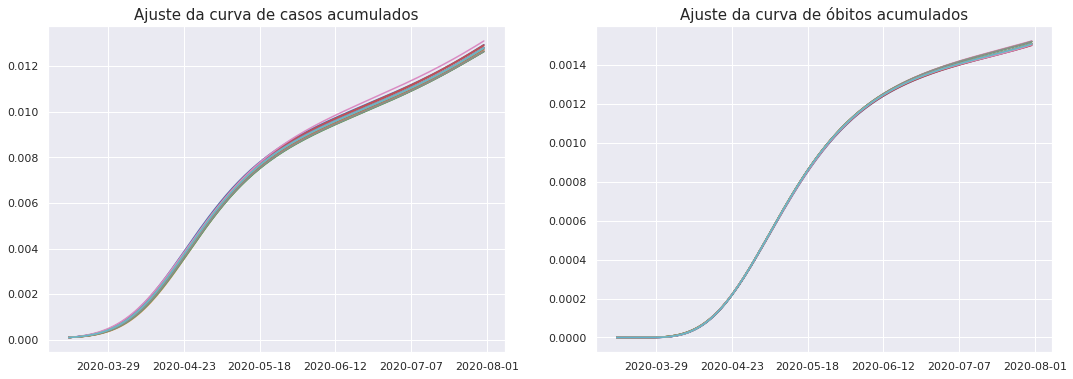

In [18]:
fig, ax = plt.subplots(1,2, figsize = (18,6))

days = data_rio[initial_day:final_day].index

x0_sampled = np.zeros((20,5))
curves_final_sampled = np.zeros((20,2))

for i in range(20):

    x0_sampled[i,:] = np.random.normal(loc = [0.8, 0.3, 5e-7, 5e-7, 5e-7], 
                                       scale = [0.1, 0.1, 2e-7, 2e-7, 2e-7])
    init_cond['x0'] = x0_sampled[i,:]

    # defines the model
    model = Fitting(p, time_varying, initial_day, final_day, hmax, init_cond)

    # estimating theta
    theta = model.fit(psi, x0, bounds)
    
    T = model.states[:,7]
    D = model.states[:,6]
    
    curves_final_sampled[i,:] = [T[-1], D[-1]]
    
    ax[0].plot(days, T)
    ax[1].plot(days, D)

ax[0].set_title('Ajuste da curva de casos acumulados', fontsize = 15)
ax[0].xaxis.set_major_locator(plt.MaxNLocator(7))
ax[1].set_title('Ajuste da curva de óbitos acumulados', fontsize = 15)
ax[1].xaxis.set_major_locator(plt.MaxNLocator(7))
    
plt.show()

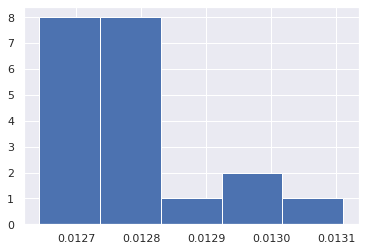

In [26]:
plt.hist(curves_final_sampled[:,0], bins = 5)
plt.show()